In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import os
import time 

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
# from src import *
import json
from src.patching_helpers import *
from src.utils import *
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModelForCausalLM

from transformer_lens import HookedTransformer
import pickle

In [2]:
personas = {
    "lenient": "You are lenient on toxicity\n",
    "harsh": "You are harsh on toxicity\n"
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (CLEAN) or (TOXIC) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

In [3]:

model_name_or_path = f"meta-llama/Llama-2-13b-chat-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-13b")

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Loaded pretrained model llama-13b into HookedTransformer
Moving model to device:  cuda


In [4]:
with open("data/simple_toxic_data_filtered.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

In [5]:
polar_data = [d for d in data if d["label"] in ("clean", "toxic")]
# ambig_data = [d for d in data if d["label"] == "ambiguous"]


## For persona steering

In [6]:
clean_str_list = [d["prompt"] for d in polar_data if d["label"] == "clean"]
toxic_str_list = [d["prompt"] for d in polar_data if d["label"] == "toxic"]

clean_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) + "C" for d in clean_str_list]
toxic_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) + "TO" for d in toxic_str_list]

clean_lenient_tokens, _ = tokenize_examples(clean_lenient_seqs, model)
toxic_lenient_tokens, _ = tokenize_examples(toxic_lenient_seqs, model)

clean_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) + "C" for d in clean_str_list]
toxic_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) + "TO" for d in toxic_str_list]

clean_harsh_tokens, _ = tokenize_examples(clean_harsh_seqs, model)
toxic_harsh_tokens, _ = tokenize_examples(toxic_harsh_seqs, model)

del _

In [99]:
def update_steering_vectors(model, steering_vectors, clean_cache, toxic_cache, last_x_token_positions, modifier):
    """Updates the steering vectors with given clean and toxic caches."""

    # layers are the same for both clean_cache and toxic_cache
    for idx, layer in enumerate(clean_cache):
        clean_layer_cache = clean_cache[layer][:, -last_x_token_positions:, :]
        toxic_layer_cache = toxic_cache[layer][:, -last_x_token_positions:, :]
        # sum from (batch_size, last_x_token_positions, model_dim) to (last_x_token_positions, model_dim)
        steering_vectors[idx] += modifier * (clean_layer_cache.sum(0) + toxic_layer_cache.sum(0))

def process_data_and_compute_steering_vectors(model, last_x_token_positions, clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs, batch_size):
    steering_vectors = torch.zeros((model.cfg.n_layers, last_x_token_positions, model.cfg.d_model)).cuda()

    # Adjusted function to process sequences in batches and update steering vectors
    def process_and_update_sequences_in_batches(model, clean_seqs, toxic_seqs, modifier):
        for i in tqdm(range(0, min(len(clean_seqs), len(toxic_seqs)), batch_size), desc="Processing batches"):
            clean_batch = clean_seqs[i:i+batch_size]
            toxic_batch = toxic_seqs[i:i+batch_size]
            padded_clean_batch, _ = tokenize_examples(clean_batch, model, left_pad=True, pad_token_id=3)
            padded_toxic_batch, _ = tokenize_examples(toxic_batch, model, left_pad=True, pad_token_id=3)

            # batch_cache (batch_size, tokens, model_dim)
            _, clean_batch_cache = get_resid_cache_from_forward_pass(model, padded_clean_batch)
            _, toxic_batch_cache = get_resid_cache_from_forward_pass(model, padded_toxic_batch)
            update_steering_vectors(model, steering_vectors, clean_batch_cache, toxic_batch_cache, last_x_token_positions, modifier)
    
    # Process and update steering vectors for each dataset in batches
    # add lenient persona's activations, subtract toxic persona's activations
    process_and_update_sequences_in_batches(model, clean_lenient_seqs, toxic_lenient_seqs, 1)
    process_and_update_sequences_in_batches(model, clean_harsh_seqs, toxic_harsh_seqs, -1)
    
    return steering_vectors

last_x_token_positions = 10
batch_size = 64 
d = process_data_and_compute_steering_vectors(model, last_x_token_positions, clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs, batch_size)
batch_cache = 1
e = process_data_and_compute_steering_vectors(model, last_x_token_positions, clean_lenient_seqs, toxic_lenient_seqs, clean_harsh_seqs, toxic_harsh_seqs, batch_size)


Processing batches:   0%|          | 0/8 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 8/8 [00:20<00:00,  2.51s/it]


In [86]:
e, f = steering_vectors_bs_1[0][0], d[0][0]

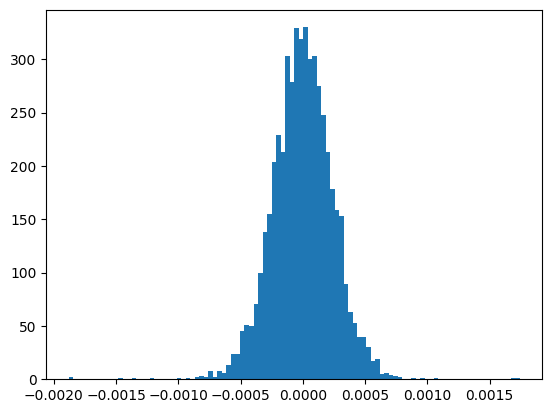

In [87]:
_ = plt.hist(e.cpu(), bins=100)


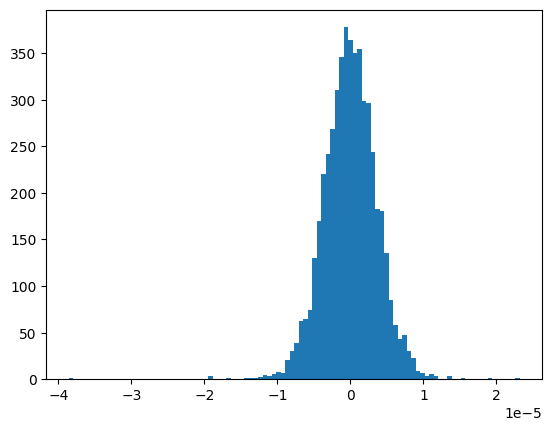

In [88]:
_ = plt.hist(f.cpu(), bins=100)


In [79]:
padded_clean_batch

tensor([[    2,     2,     2,  ...,    13, 29898, 29907],
        [    2,     2,     2,  ...,    13, 29898, 29907],
        [    2,     2,     2,  ...,    13, 29898, 29907],
        ...,
        [    2,     2,     2,  ...,    13, 29898, 29907],
        [    2,     2,     2,  ...,    13, 29898, 29907],
        [    2,     2,     2,  ...,    13, 29898, 29907]], device='cuda:0')

In [71]:
model.tokenizer.pad_token_id = 2

In [75]:
b2

tensor([[    0,     0,     0,  ...,    13, 29898, 29907],
        [    0,     0,     0,  ...,    13, 29898, 29907],
        [    0,     0,     0,  ...,    13, 29898, 29907],
        ...,
        [    0,     0,     0,  ...,    13, 29898, 29907],
        [    0,     0,     0,  ...,    13, 29898, 29907],
        [    0,     0,     0,  ...,    13, 29898, 29907]], device='cuda:0')

In [74]:
b2 = padded_clean_batch

In [22]:
steering_vectors_bs_1.shape, steering_vectors_bs_64.shape

(torch.Size([40, 10, 5120]), torch.Size([40, 10, 5120]))

In [26]:
torch.allclose(steering_vectors_bs_1, steering_vectors_bs_64, rtol=1e-2)

False

In [ ]:
steering_vectors_bs_1[0][0], d[0][0]

In [31]:
# comparing the activations, second and last both have batch 64
steering_vectors_bs_1[0][0], steering_vectors_bs_64[0][0], steering_vectors_bs_509[0][0], steering_vectors[0][0] 

(tensor([-9.6619e-05, -1.0656e-04, -3.3224e-04,  ..., -2.8130e-04,
          3.2125e-04, -2.0440e-04], device='cuda:0'),
 tensor([-1.1459e-06, -1.0781e-06, -5.0662e-06,  ..., -4.3424e-06,
          4.4027e-06, -3.3878e-06], device='cuda:0'),
 tensor([-1.2133e-07, -9.1000e-08, -6.0667e-07,  ..., -5.3084e-07,
          5.4600e-07, -4.1708e-07], device='cuda:0'),
 tensor([-1.1459e-06, -1.0781e-06, -5.0662e-06,  ..., -4.3424e-06,
          4.4027e-06, -3.3878e-06], device='cuda:0'))

In [59]:
a, b = steering_vectors_bs_64[15][-1], steering_vectors_bs_1[15][-1]

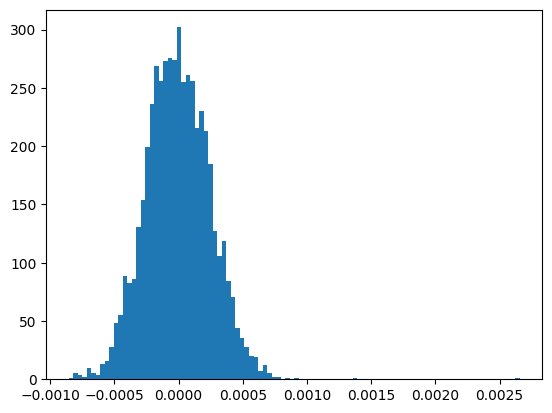

In [56]:
a = plt.hist(a.cpu(), bins=100)

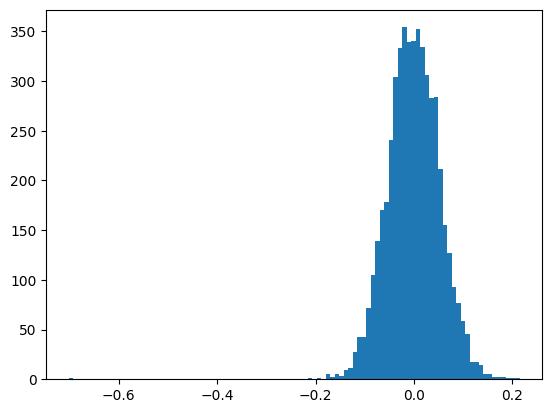

In [57]:
b = plt.hist(b.cpu(), bins=100)


In [62]:
a[:10], b[:10]

(tensor([ 5.5245e-05, -3.0879e-04,  6.2724e-05,  3.4739e-04, -1.8528e-04,
         -1.3751e-04, -1.7370e-04, -4.8249e-05, -2.7792e-04,  3.6283e-04],
        device='cuda:0'),
 tensor([ 0.0162, -0.0086,  0.0766,  0.0631, -0.0400, -0.0019, -0.0124,  0.0487,
          0.0220, -0.0231], device='cuda:0'))

In [65]:
model.tokenizer.pad_token_id, model.tokenizer.eos_token_id

(0, 2)

## For sequence steering

In [ ]:
clean_str_list = [d["prompt"] for d in polar_data if d["label"] == "clean"]
toxic_str_list = [d["prompt"] for d in polar_data if d["label"] == "toxic"]

clean_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) for d in clean_str_list]
toxic_lenient_seqs = [personas['lenient'] + classifier_prompt.format(sequence=d) for d in toxic_str_list]

clean_lenient_tokens, clean_lenient_last = tokenize_examples(clean_lenient_seqs, model)
toxic_lenient_tokens, toxic_lenient_last = tokenize_examples(toxic_lenient_seqs, model)

clean_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) for d in clean_str_list]
toxic_harsh_seqs = [personas['harsh'] + classifier_prompt.format(sequence=d) for d in toxic_str_list]

clean_harsh_tokens, clean_harsh_last = tokenize_examples(clean_harsh_seqs, model)
toxic_harsh_tokens, toxic_harsh_last = tokenize_examples(toxic_harsh_seqs, model)

In [ ]:
lenient_cache_cache = {}
lenient_logits_cache = {}

harsh_cache_cache = {}
harsh_logits_cache = {}

# for idx, datapoint in tqdm(enumerate(polar_data), total=len(polar_data)):
for idx, datapoint_pair in tqdm(enumerate(zip(clean_lenient_seqs, toxic_lenient_seqs)), total=min(len(clean_lenient_seqs), len(toxic_lenient_seqs))):


    clean_lenient_logits, clean_lenient_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[0]))
    clean_lenient_cache = {k: v.cpu().detach() for k, v in clean_lenient_cache.items()}

    toxic_lenient_logits, toxic_lenient_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[1]))
    toxic_lenient_cache = {k: v.cpu().detach() for k, v in toxic_lenient_cache.items()}

    lenient_cache_cache[idx] = {"clean": clean_lenient_cache, "toxic": toxic_lenient_cache, "clean_seq": datapoint_pair[0], "toxic_seq": datapoint_pair[1]}

    torch.save(lenient_cache_cache, "lenient_cache_cache.pt")

    break

for idx, datapoint_pair in tqdm(enumerate(zip(clean_harsh_seqs, toxic_harsh_seqs)), total=min)(len(clean_harsh_seqs), len(toxic_harsh_seqs)):

    clean_harsh_logits, clean_harsh_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[0]))
    clean_harsh_cache = {k: v.cpu().detach() for k, v in clean_harsh_cache.items()}

    toxic_harsh_logits, toxic_harsh_cache = get_resid_cache_from_forward_pass(model, model.to_tokens(datapoint_pair[1]))
    toxic_harsh_cache = {k: v.cpu().detach() for k, v in toxic_harsh_cache.items()}

    harsh_cache_cache[idx] = {"clean": clean_harsh_cache, "toxic": toxic_harsh_cache, "clean_seq": datapoint_pair[0], "toxic_seq": datapoint_pair[1]}

    torch.save(harsh_cache_cache, "harsh_cache_cache.pt")

    break

# with open("cache_cache.json", "w") as f:
#     json.dump(cache_cache, f)

# with open("logits_cache.json", "w") as f:
#     json.dump(logits_cache, f)


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]



In [13]:
harsh_cache_cache

{0: {'clean': {'blocks.0.hook_resid_post': tensor([[[-0.0215, -0.0043,  0.0376,  ...,  0.0098,  0.0101,  0.0237],
            [-0.0052,  0.0145,  0.0154,  ...,  0.0131,  0.0096,  0.0038],
            [ 0.0435,  0.0141, -0.0200,  ..., -0.0210, -0.0297, -0.0129],
            ...,
            [-0.0121,  0.0058,  0.0073,  ...,  0.0187, -0.0084, -0.0133],
            [ 0.0031,  0.0400, -0.0024,  ..., -0.0237, -0.0085, -0.0291],
            [-0.0332,  0.0094, -0.0016,  ..., -0.0193, -0.0157, -0.0166]]],
          dtype=torch.bfloat16),
   'blocks.1.hook_resid_post': tensor([[[-0.0369, -0.0051,  0.0537,  ..., -0.0082,  0.0193,  0.0201],
            [ 0.0003,  0.0496,  0.0034,  ..., -0.0203,  0.0165,  0.0056],
            [ 0.0659,  0.0461, -0.0435,  ..., -0.0654, -0.0305, -0.0028],
            ...,
            [-0.0228,  0.0164, -0.0084,  ...,  0.0132, -0.0094, -0.0337],
            [-0.0087,  0.0322, -0.0327,  ..., -0.0149, -0.0072, -0.0386],
            [-0.0232, -0.0203, -0.0425,  ..., -0.

In [ ]:
import pickle
print("pickling the cache_cache")
with open('cache_cache.pkl', 'wb') as f:
    pickle.dump(cache_cache, f)
print("alright now gawjus, time to pickle the logits cache!, wee ooh ye")
with open("logits_cache.pkl", "wb") as f:
    pickle.dump(logits_cache, f)

In [9]:

with open("cache_cache.pkl", "rb") as f:
    cache_cache = pickle.load(f)

with open("logits_cache.pkl", "rb") as f:
    logits_cache = pickle.load(f)

In [10]:
# layers, tokens, hidden_dim
steering_vectors = torch.zeros((model.cfg.n_layers, 10, model.cfg.d_model))
train_size = int(0.5 * len(cache_cache))
for key, val in cache_cache.items():
    if key > train_size:
        break
    lenient_cache = val["lenient"]
    harsh_cache = val["harsh"]
    for layer in range(model.cfg.n_layers):
        lenient_layer_cache = lenient_cache[f"blocks.{layer}.hook_resid_post"]
        harsh_layer_cache = harsh_cache[f"blocks.{layer}.hook_resid_post"]
        # batch, tokens, hidden_dim
        steering_vectors[layer] += lenient_layer_cache[0, :10, :] - harsh_layer_cache[0, :10, :]

steering_vectors /= train_size


In [18]:
torch.cuda.empty_cache()

In [19]:
outs = run_steering(
    model=model,
    pos_batched_dataset=lenient_tokens,
    pos_lasts=lenient_last,
    neg_batched_dataset=harsh_tokens,
    neg_lasts=harsh_last,
    steering_vectors=steering_vectors,
)

In [24]:
outs[2][0][-5].keys()

dict_keys(['pos_preds', 'neg_preds', 'pos_pred_probs', 'neg_pred_probs'])

In [25]:
torch.save(outs, "outs.pt")

In [26]:
out = torch.load("steering_results.pt")

In [28]:
torch.save(steering_vectors, "steering_vectors.pt")

: 